# Fluxonium

## Initialization (load modules etc.)

In [1]:
%pylab inline

from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import sc_qubits2 as qubit  # import the superconducting circuit module
import plotting as plot

from qutip import *

Populating the interactive namespace from numpy and matplotlib


## Fluxonium qubit

$H_\text{fl}=-4E_\text{C}\partial_\phi^2-E_\text{J}\cos(\phi-\varphi_\text{ext}) +\frac{1}{2}E_L\phi^2$

In [2]:
fluxonium = qubit.Fluxonium(
    EJ = 8.14482,
    EC = 0.452597,
    EL = 0.24843,
    flux = 0.0,
    cutoff = 110,
    truncated_dim = 10
)

In [3]:
fluxonium

fluxonium -- PARAMETERS -------
EC	: 0.452597
EJ	: 8.14482
EL	: 0.24843
cutoff	: 110
flux	: 0.0
truncated_dim	: 10
Hilbert space dimension	: 110

In [4]:
fluxonium.eigenvals()

array([-5.97725297, -1.24856717, -1.24856027, -0.94759015,  3.50536303,
        3.68325135])


[====================] 100% Done.


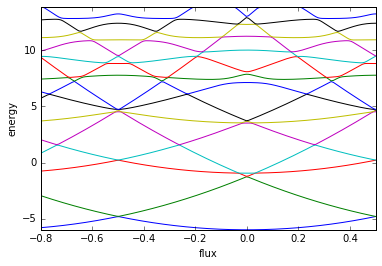

In [5]:
flux_list = np.linspace(-0.8, 0.5, 151)
fluxonium.plot_evals_vs_paramvals('flux', flux_list, evals_count=15)


[====================] 100% Done.


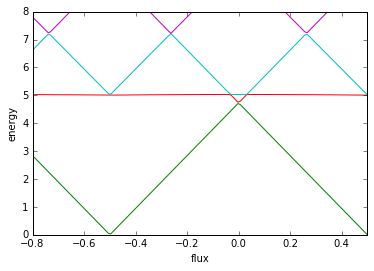

In [6]:
fluxonium.plot_evals_vs_paramvals('flux', flux_list, evals_count=10, subtract_ground=True, yrange=[0,8])

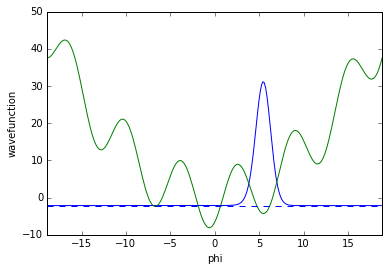

In [7]:
fluxonium.flux=0.1
fluxonium.plot_wavefunction(esys=None, which=1, mode='real')

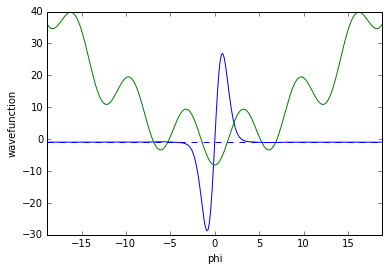

In [8]:
fluxonium.flux=0.0
fluxonium.plot_wavefunction(esys=None, which=3, mode='real')

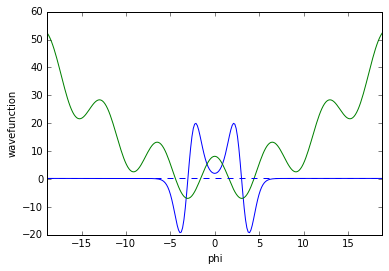

In [9]:
fluxonium.flux=0.5
fluxonium.plot_wavefunction(esys=None, which=2, mode='real')

### Charge matrix elements @ flux=0

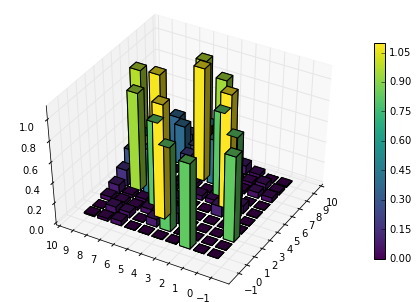

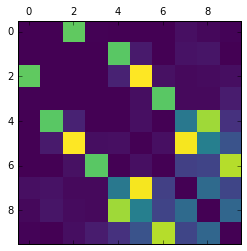

In [6]:
fluxonium.flux = 0.05
fluxonium.plot_matrixelements('n_operator', evals_count=10)

### Charge matrix elements from ground state to higher states vs. flux

In [7]:
fluxpts = 191
levls = 8
matelem_data = np.zeros(shape=[fluxpts,levls], dtype=np.complex_)
flux_vals = np.linspace(-0.5, 0.5, fluxpts)

for j, flux in enumerate(flux_vals):
    fluxonium.flux = flux
    matelem_data[j] = fluxonium.matrixelement_table('n_operator', esys=None, evals_count=levls)[0, 0:8]

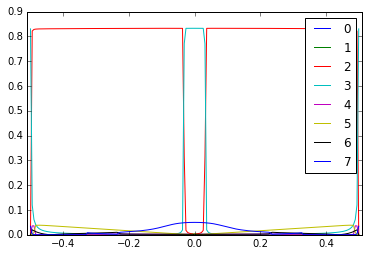

In [8]:
for j in range(levls):
    plt.plot(flux_vals, np.abs(matelem_data[:,j]), label=str(j))
    plt.xlim(-0.51,0.51)
plt.legend()
plt.show()

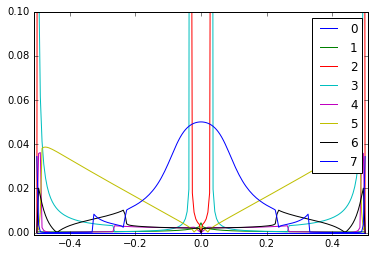

In [13]:
for j in range(levls):
    plt.plot(flux_vals, np.abs(matelem_data[:,j]), label=str(j))
    plt.xlim(-0.51,0.51)
    plt.ylim(-0.001,0.1)
plt.legend()

plt.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


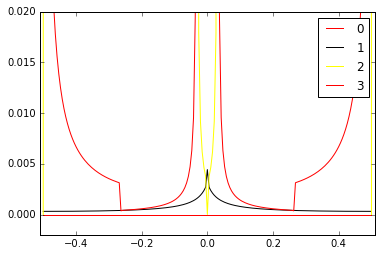

In [9]:
fig, ax = plt.subplots()
ax.set_color_cycle(['red', 'black', 'yellow'])
for j in range(4):
    plt.plot(flux_vals, np.abs(matelem_data[:,j]), label=str(j))
    plt.xlim(-0.51,0.51)
    plt.ylim(-0.002,0.02)
plt.legend()
plt.show()

## Fluxonium coupled to resonator

$\displaystyle H=\sum_{j} E_j| j\rangle\langle  j| + \omega_r a^\dagger a + \sum_{j,k}g_{jk} | j\rangle \langle  k|(a+a^\dagger)$

### Define Hilbert space, Hamiltonian

In [10]:
# Set up the components / subspaces of our Hilbert space

resonator = qubit.Oscillator(
    omega = 4.95,
    truncated_dim=5
)

fluxonium = qubit.Fluxonium(
    EJ = 8.14482,
    EC = 0.452597,
    EL = 0.24843,
    flux = 0.0,
    cutoff = 110,
    truncated_dim = 10
)

hilbertspc = qubit.HilbertSpace([fluxonium, resonator])


# Get resonator Hamiltonian (full product Hilbert space)
h_res = hilbertspc.diag_hamiltonian(resonator)

In [11]:
hilbertspc

====== HILBERT SPACE OBJECT ======
subsystem_list	: [fluxonium -- PARAMETERS -------
EC	: 0.452597
EJ	: 8.14482
EL	: 0.24843
cutoff	: 110
flux	: 0.0
truncated_dim	: 10
Hilbert space dimension	: 110, Oscillator -- PARAMETERS -------
truncated_dim	: 5
omega	: 4.95]

dimension	: 50

subsystem_count	: 2

subsystem_dims	: [10, 5]

In [12]:
g = 0.085  # coupling resonator-fluxonium (without charge matrix elements)

hbd = hilbertspc.hubbard_operator
a = hilbertspc.annihilate(resonator)

dim1 = fluxonium.truncated_dim
# Spectrum when varying flux
# Set up Hamiltonian:

def hamiltonian(flux):
    fluxonium.flux = flux
    
    esys = fluxonium.eigensys(evals_count=dim1)
    gmat = g * fluxonium.matrixelement_table('n_operator', esys=esys, evals_count=dim1)   # coupling constants
    
    h_fl = hilbertspc.diag_hamiltonian(fluxonium)
    v = sum([gmat[j][k] * hbd(j,k,fluxonium) for j in range(dim1) for k in range(dim1)])
    
    return (h_fl + h_res + v*(a + a.dag()))

### Specify initial state for transition in terms of *bare fluxonium and resonator states*

This is useful for understanding nature of lines in absorption/emission spectra.

In [13]:
flux_list = np.linspace(-0.1, 0.6, 100)
specdata = hilbertspc.get_spectrum_vs_paramvals(hamiltonian, flux_list, evals_count=15, get_eigenstates=True, filename='./data/test')


[====================] 100% Done.


In [23]:
spec_f0r0 = hilbertspc.absorption_spectrum(specdata, ((fluxonium, 0), (resonator, 0)), initial_as_bare=True)
spec_f1r0 = hilbertspc.absorption_spectrum(specdata, ((fluxonium, 1), (resonator, 0)), initial_as_bare=True)
spec_f0r1 = hilbertspc.absorption_spectrum(specdata, ((fluxonium, 0), (resonator, 1)), initial_as_bare=True)
spec_f2r0 = hilbertspc.absorption_spectrum(specdata, ((fluxonium, 2), (resonator, 0)), initial_as_bare=True)


[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.


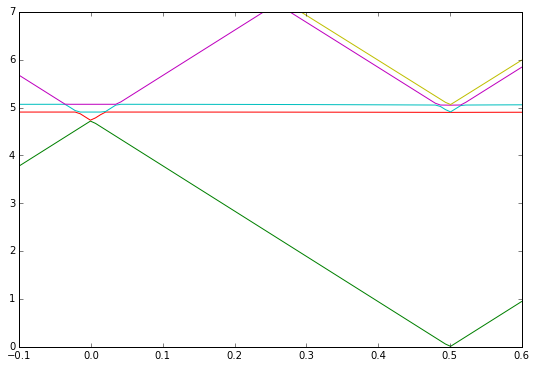

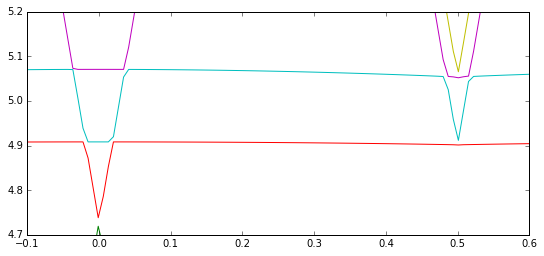

In [24]:
plt.figure(figsize=(9,6))
plt.plot(spec_f0r0.param_vals, spec_f0r0.energy_table)
plt.ylim(0,7)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(spec_f0r0.param_vals, spec_f0r0.energy_table)
plt.ylim(4.7, 5.2)
plt.show()

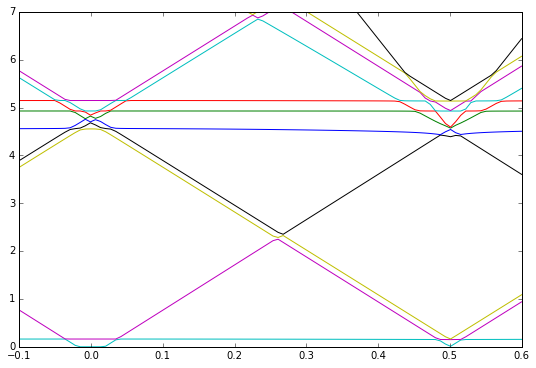

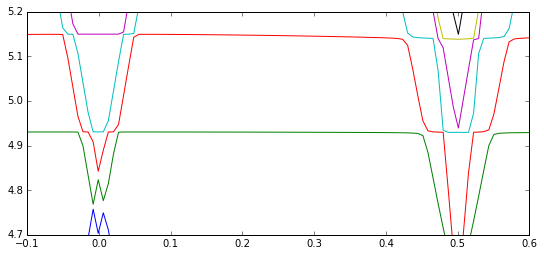

In [25]:
plt.figure(figsize=(9,6))
plt.plot(spec_f0r1.param_vals, spec_f0r1.energy_table)
plt.ylim(0,7)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(spec_f0r1.param_vals, spec_f0r1.energy_table)
plt.ylim(4.7, 5.2)
plt.show()

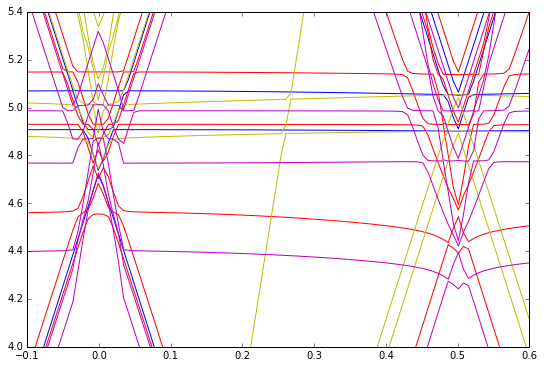

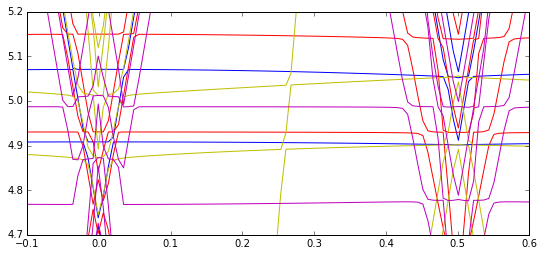

In [26]:
plt.figure(figsize=(9,6))
plt.plot(flux_list, spec_f0r0.energy_table, c='b')
plt.plot(flux_list, spec_f0r1.energy_table, c='r')
plt.plot(flux_list, spec_f1r0.energy_table, c='y')
plt.plot(flux_list, spec_f2r0.energy_table, c='m')
plt.ylim(4.0,5.4)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(flux_list, spec_f0r0.energy_table, c='b')
plt.plot(flux_list, spec_f0r1.energy_table, c='r')
plt.plot(flux_list, spec_f1r0.energy_table, c='y')
plt.plot(flux_list, spec_f2r0.energy_table, c='m')
plt.ylim(4.7,5.2)
plt.show()

In [27]:
flux_list05 = np.linspace(0.485, 0.515, 300)
specdata05 = hilbertspc.get_spectrum_vs_paramvals(hamiltonian, flux_list05, evals_count=15, get_eigenstates=True)

flux_list0 = np.linspace(-0.15, 0.15, 300)
specdata0 = hilbertspc.get_spectrum_vs_paramvals(hamiltonian, flux_list0, evals_count=15, get_eigenstates=True)


[====================] 100% Done.

[====================] 100% Done.


In [29]:
spec0_f0r0 = hilbertspc.absorption_spectrum(specdata0, ((fluxonium, 0), (resonator, 0)), initial_as_bare=True)
spec0_f1r0 = hilbertspc.absorption_spectrum(specdata0, ((fluxonium, 1), (resonator, 0)), initial_as_bare=True)
spec0_f0r1 = hilbertspc.absorption_spectrum(specdata0, ((fluxonium, 0), (resonator, 1)), initial_as_bare=True)
spec0_f2r0 = hilbertspc.absorption_spectrum(specdata0, ((fluxonium, 2), (resonator, 0)), initial_as_bare=True)

spec05_f0r0 = hilbertspc.absorption_spectrum(specdata05, ((fluxonium, 0), (resonator, 0)), initial_as_bare=True)
spec05_f1r0 = hilbertspc.absorption_spectrum(specdata05, ((fluxonium, 1), (resonator, 0)), initial_as_bare=True)
spec05_f0r1 = hilbertspc.absorption_spectrum(specdata05, ((fluxonium, 0), (resonator, 1)), initial_as_bare=True)
spec05_f2r0 = hilbertspc.absorption_spectrum(specdata05, ((fluxonium, 2), (resonator, 0)), initial_as_bare=True)


[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.


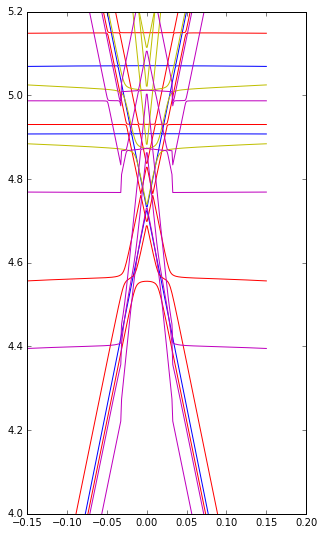

In [30]:
plt.figure(figsize=(5,9))
plt.ylim(4.0,5.2)

plt.plot(flux_list0, spec0_f0r0.energy_table, c='b')
plt.plot(flux_list0, spec0_f0r1.energy_table, c='r')
plt.plot(flux_list0, spec0_f1r0.energy_table, c='y')
plt.plot(flux_list0, spec0_f2r0.energy_table, c='m')
plt.show()

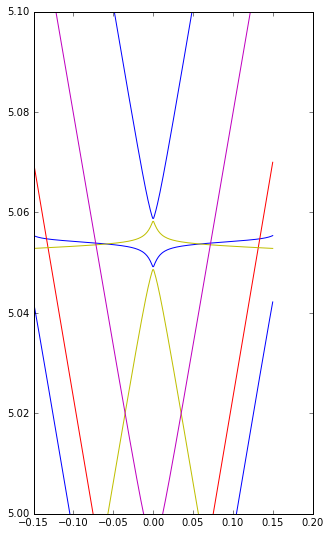

In [31]:
plt.figure(figsize=(5,9))
plt.ylim(5.0,5.1)

plt.plot(flux_list0, spec05_f0r0.energy_table, c='b')
plt.plot(flux_list0, spec05_f0r1.energy_table, c='r')
plt.plot(flux_list0, spec05_f1r0.energy_table, c='y')
plt.plot(flux_list0, spec05_f2r0.energy_table, c='m')
plt.show()

Caveat: vertical line segments below are likely to come from switching between two dressed states, while trying to stay close to the bare initial state.

### Specify initial state for transition in terms of *dressed state index*

This is useful for fitting.

In [32]:
spec_0 = hilbertspc.absorption_spectrum(specdata0, 0)
spec_1 = hilbertspc.absorption_spectrum(specdata0, 1)
spec_2 = hilbertspc.absorption_spectrum(specdata0, 2)
spec_3 = hilbertspc.absorption_spectrum(specdata0, 3)


[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.

[====================] 100% Done.


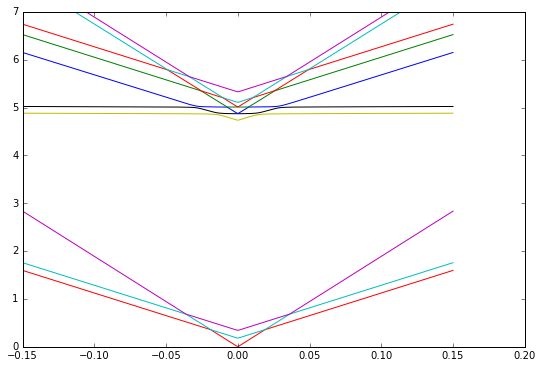

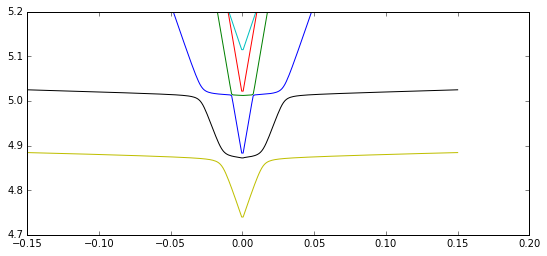

In [35]:
plt.figure(figsize=(9,6))
plt.plot(spec_1.param_vals, spec_1.energy_table)
plt.ylim(0,7)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(spec_1.param_vals, spec_1.energy_table)
plt.ylim(4.7, 5.2)
plt.show()

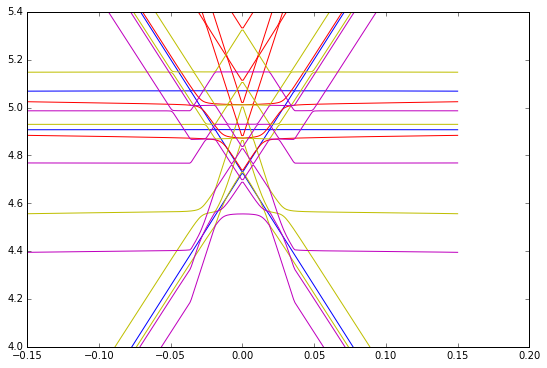

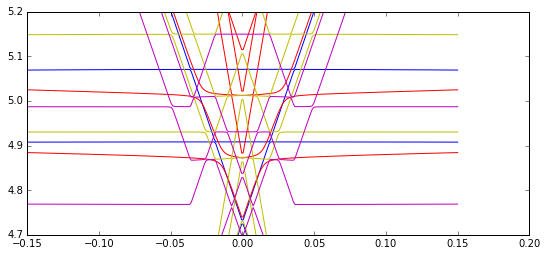

In [37]:
plt.figure(figsize=(9,6))
plt.plot(spec_0.param_vals, spec_0.energy_table, c='b')
plt.plot(spec_1.param_vals, spec_1.energy_table, c='r')
plt.plot(spec_2.param_vals, spec_2.energy_table, c='y')
plt.plot(spec_3.param_vals, spec_3.energy_table, c='m')
plt.ylim(4.0,5.4)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(spec_0.param_vals, spec_0.energy_table, c='b')
plt.plot(spec_1.param_vals, spec_1.energy_table, c='r')
plt.plot(spec_2.param_vals, spec_2.energy_table, c='y')
plt.plot(spec_3.param_vals, spec_3.energy_table, c='m')
plt.ylim(4.7,5.2)
plt.show()

Note: spurious vertical lines are indeed gone.

### Consideration of transitions based on charge matrix elements
- Single-tone experiments: expect that hybridization with resonator is required. Consider $\langle a^\dagger a\rangle$
- Two-tone experiments: consider charge-matrix elements between states participating in the transition.

In [14]:
#Obtaining data, in this case eigenvalues and eigenstates
ev_no = 15
fluxval_count = 100
flux_list = np.linspace(-0.1, 0.6, fluxval_count)
specdata = hilbertspc.get_spectrum_vs_paramvals(hamiltonian, flux_list, evals_count=ev_no, get_eigenstates=True)
absorptiondata = hilbertspc.absorption_spectrum(specdata, 0)


[====================] 100% Done.

[====================] 100% Done.


In [15]:
n_res = a.dag()*a

adag_a_data = np.empty((fluxval_count, ev_no), dtype=np.complex_)
for fluxval_index in range(fluxval_count):
    for state_index in range(ev_no):
        adag_a_data[fluxval_index][state_index] = qubit.matrix_element(specdata.state_table[fluxval_index][state_index],
                                                                       n_res,
                                                                       specdata.state_table[fluxval_index][state_index])

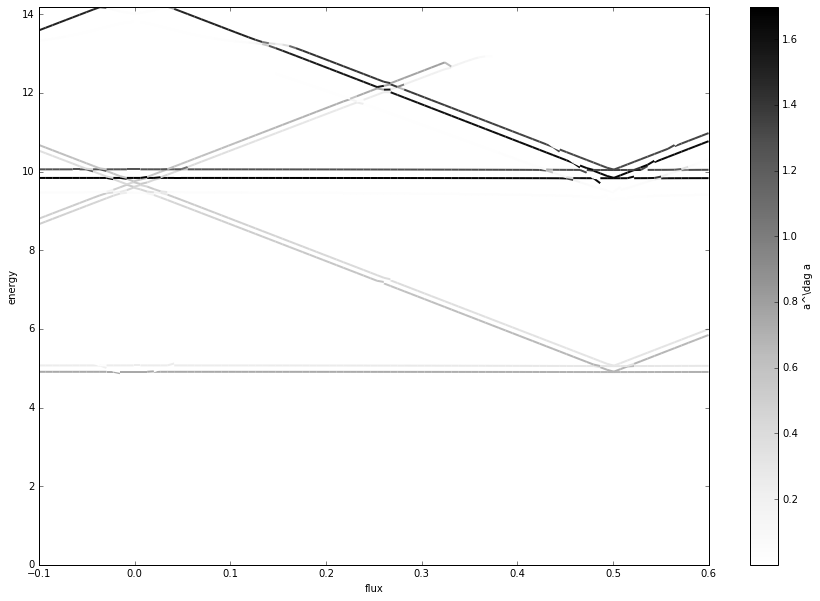

In [16]:
plot.spectrum_with_matrixelement(absorptiondata, np.abs(adag_a_data), param_name='flux', energy_name='energy', matrixelement_name='a^\dag a',
                                 colormap='Greys')

In [18]:
fdim = fluxonium.truncated_dim

charge_op_data = np.empty((fluxval_count, ev_no), dtype=np.complex_)

for fluxval_index, flux in enumerate(flux_list):
    fluxonium.flux = flux
    esys = fluxonium.eigensys(evals_count=fdim)
    n_mat = fluxonium.matrixelement_table('n_operator', esys=esys, evals_count=fdim)   # coupling constants
    v = sum([n_mat[j][k] * hbd(j,k,fluxonium) for j in range(fdim) for k in range(fdim)])
    for state_index in range(ev_no):
        charge_op_data[fluxval_index][state_index] = qubit.matrix_element(specdata.state_table[fluxval_index][0],
                                                                          v,
                                                                          specdata.state_table[fluxval_index][state_index])

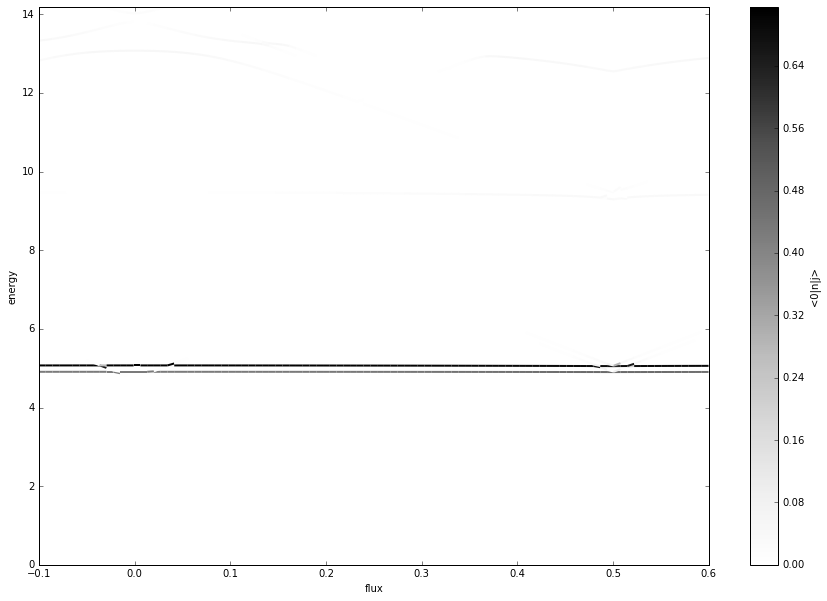

In [19]:
plot.spectrum_with_matrixelement(absorptiondata, np.abs(charge_op_data), param_name='flux', energy_name='energy', matrixelement_name='<0|n|j>',
                                 colormap='Greys')